In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [218]:
import numpy as np
import pickle
from tabulate import tabulate
from functools import partial
import ctypes
from scipy.optimize import minimize, LinearConstraint, dual_annealing, Bounds, NonlinearConstraint
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats.qmc import Sobol, Halton
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt 
import multiprocessing, tqdm
from bgspy.likelihood import negll_c, negll, negll_numba
from bgspy.likelihood import bounds_simplex, random_start_simplex, random_start_mutation
from bgspy.likelihood import negll_mutation, bounds_mutation
from bgspy.likelihood import penalized_negll_c

In [192]:
def nloptim_summary(run_res, nt, nf, mle_rank=0, nll=None):
    nlls, thetas, success = run_res
    ranks = np.argsort(nlls)
    best_idx = ranks[mle_rank]
    theta = thetas[best_idx]
    nll = nlls[best_idx]
    print(f"convergence: {np.round(np.mean(success > 0), 2)*100}%")
    print(f"NLL: {nll}\npi0: {theta[0]}\n")
    print(f"μ: {theta[1]}\nW = ")
    W = theta[2:].reshape((nt, nf))
    print(tabulate(np.round(W, 3)))
    print(f"sums: {W.sum(axis=0)}")
    return theta

def summarize_optims(res):
    # for scipy
    nlls, thetas, success = res
    x = thetas[np.argmin(nlls)]
    ll = np.min(nlls) / 1e11
    pi0 = x[0]
    w = x[2:]/x[2:].sum()
    mu = x[2:].sum()
    print(f"convergence: {np.round(np.mean(success), 2)*100}%")
    print(f"neg loglik (x1e11) = {ll}\nμ = {mu}\nπ0 = {pi0}\nw = {w}\n")

def check_bounds(x, lb, ub):
    assert np.all((x >= lb) & (x <= ub))

In [17]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

## Load data and define some functions

In [4]:
dat = pickle.load(open('../tests/likelihood_test_data.pkl', 'rb'))
B, Bp, Y, w = dat['B'], dat['Bp'], dat['Y'], dat['w']

nx, nw, nt, nf = B.shape
nparams = nt * nf + 2

In [58]:
def optim_plot(tail=0.5, **runs):
    fig, ax = plt.subplots()
    for i, (key, run) in enumerate(runs.items()):
        nll = run[0]
        succ = run[2]
        q = np.quantile(nll, tail)
        nlls = nll[nll < q]
        sort_idx = np.argsort(nlls)
        y = nlls[sort_idx]
        x = 2*i + succ[nll < q].astype('int')
        cols = mpl.cm.get_cmap('Paired')(x)
        ax.scatter(list(reversed(range(len(y)))), y, s=1, label=key, c=cols)
    ax.legend()

# Free-Mutation Model (SciPy)

Here we try a less-constrained form of optimization: a separate mutation rate per feature/selection class. This minimizes constraints — all we need are bounds. But, there are an extra two degrees of freedom. The simpler constraints mean that SciPy's optimiation function will work fine.

## Free-Mutation Model with Reduced Features Model

Here we try the simplest test case: only one column of features (CDS) of the test human data.
 

In [220]:
def negll_freemut(Y, B, w):
    def func(theta):
        new_theta = np.zeros(theta.size + 1)
        new_theta[0] = theta[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = theta[1:] # times mutation rates        
        return negll_c(new_theta, Y, B, w)
    return func

def run_optims(workerfunc, startfunc, nstarts, ncores = 50):
    starts = [startfunc() for _ in range(nstarts)]
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
    nlls = np.array([x.fun for x in res])
    thetas = np.array([x.x for x in res])
    success = np.array([x.success for x in res])
    return nlls, thetas, success
    

In [60]:
nllBp = negll_freemut(Y, Bp[..., 0][..., None], w)
nllB = negll_freemut(Y, B[..., 0][..., None], w)


def worker_Bp_reduced(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, 1, paired=True), method='L-BFGS-B')

def worker_B_reduced(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, 1, paired=True), method='L-BFGS-B')

resB_reduced = run_optims(worker_B_reduced, partial(random_start_mutation, nt, 1), 1000)
resBp_reduced = run_optims(worker_Bp_reduced, partial(random_start_mutation, nt, 1), 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.63it/s]


In [54]:
summarize_optims(resB_reduced)
summarize_optims(resBp_reduced)

convergence: 86.0%
neg loglik (x1e11) = 9.135707071705916
μ = 9.563630082935192e-08
π0 = 0.0018976206388014861
w = [6.62607879e-01 2.39507301e-01 1.04562806e-04 1.04562806e-04
 1.04562806e-04 1.04562806e-04 1.04562806e-04 2.63681686e-04
 1.38641070e-03 1.12688330e-02 1.00492391e-02 4.20878359e-02
 1.74590083e-02 1.48469976e-02]

convergence: 81.0%
neg loglik (x1e11) = 9.135709413339473
μ = 6.050563618297347e-08
π0 = 0.00185718862851748
w = [4.16332534e-01 4.18378630e-01 2.71537475e-03 4.15983920e-04
 4.08758082e-03 2.71537475e-03 4.20061095e-04 4.43810424e-03
 5.88162759e-03 1.60016380e-02 8.71945182e-03 4.33599083e-02
 4.61695086e-02 3.03642221e-02]



[]

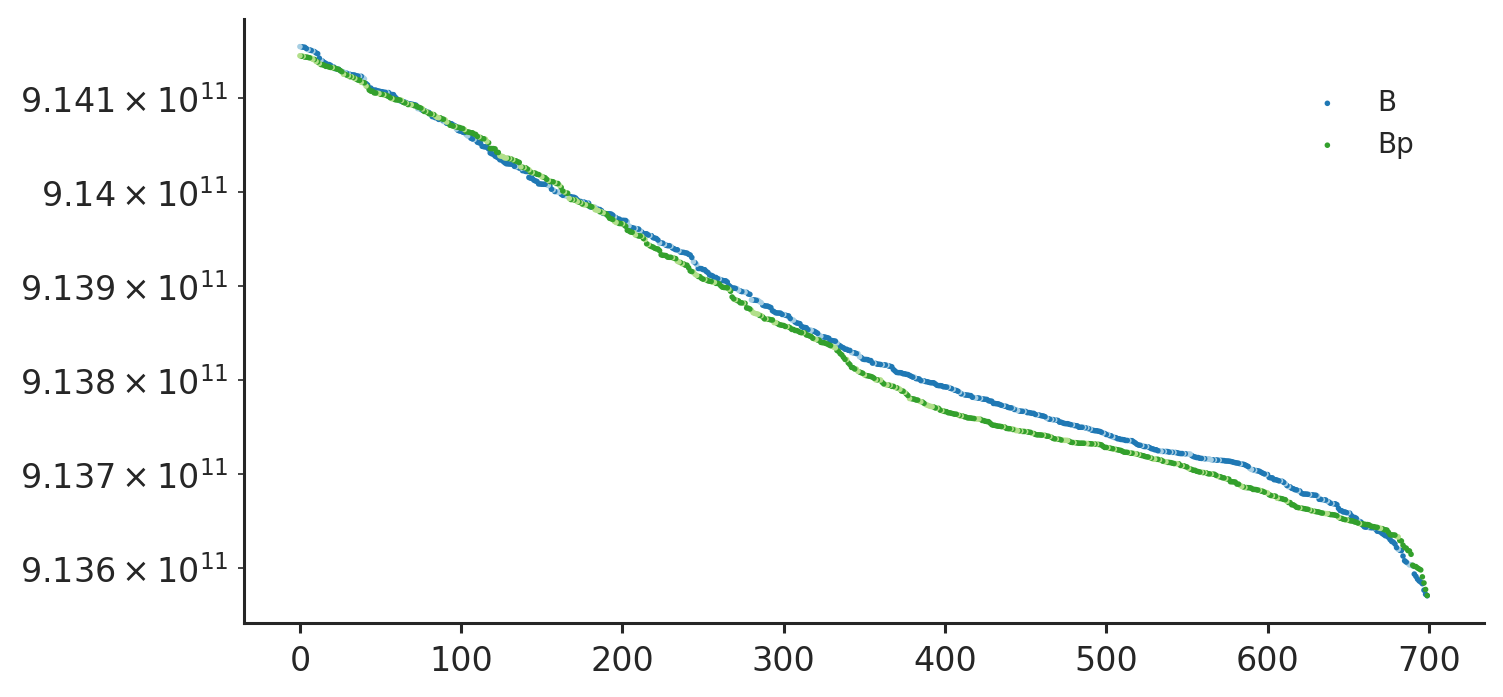

In [56]:
optim_plot(B=resB_reduced, Bp=resBp_reduced, tail=0.7)
plt.semilogy()

## Free-Mutation Model (All Features)

In [48]:
nllBp = negll_freemut(Y, Bp, w)
nllB = negll_freemut(Y, B, w)

def worker_Bp_full(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

def worker_B_full(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

resB = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 1000)
resBp = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


In [61]:
summarize_optims(resB)
summarize_optims(resBp)

convergence: 86.0%
neg loglik (x1e11) = 9.135707071705916
μ = 9.563630082935192e-08
π0 = 0.0018976206388014861
w = [6.62607879e-01 2.39507301e-01 1.04562806e-04 1.04562806e-04
 1.04562806e-04 1.04562806e-04 1.04562806e-04 2.63681686e-04
 1.38641070e-03 1.12688330e-02 1.00492391e-02 4.20878359e-02
 1.74590083e-02 1.48469976e-02]

convergence: 81.0%
neg loglik (x1e11) = 9.135709413339473
μ = 6.050563618297347e-08
π0 = 0.00185718862851748
w = [4.16332534e-01 4.18378630e-01 2.71537475e-03 4.15983920e-04
 4.08758082e-03 2.71537475e-03 4.20061095e-04 4.43810424e-03
 5.88162759e-03 1.60016380e-02 8.71945182e-03 4.33599083e-02
 4.61695086e-02 3.03642221e-02]



[]

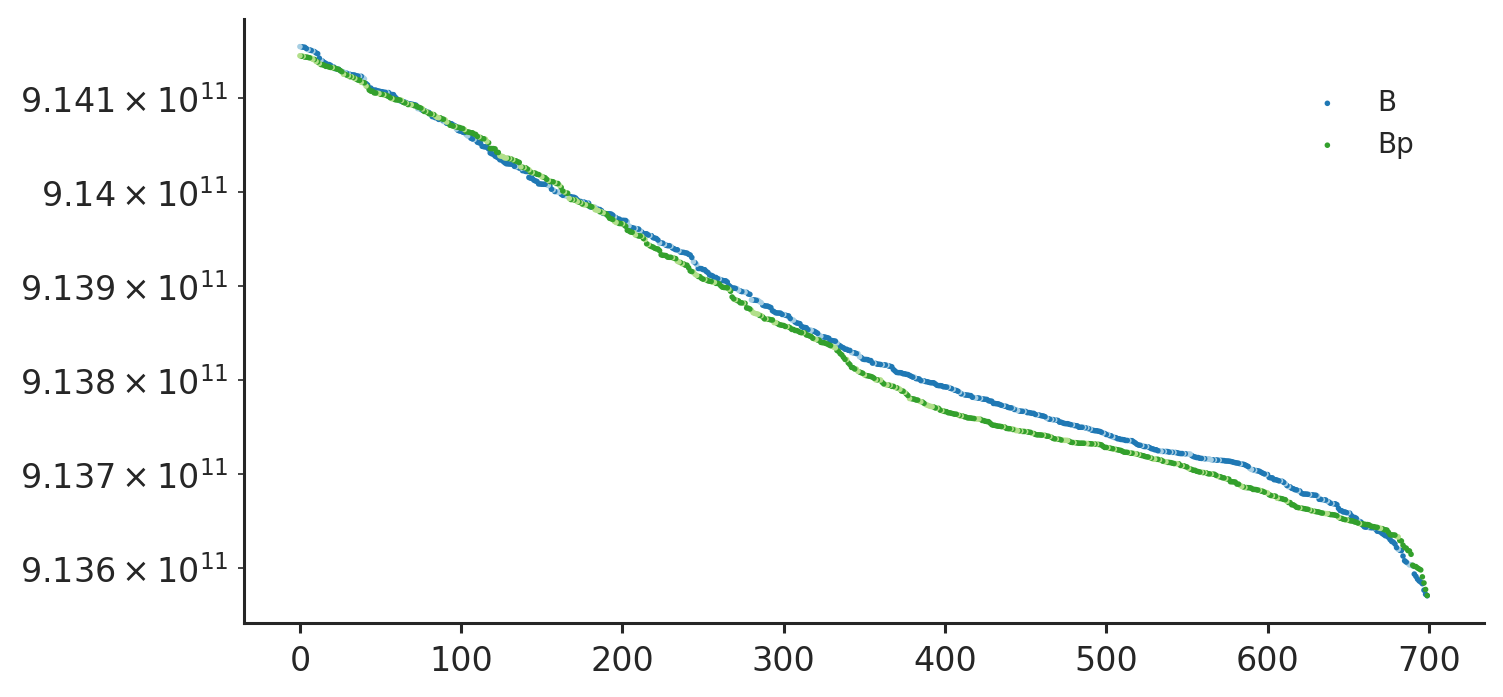

In [62]:
optim_plot(B=resB, Bp=resBp, tail=0.7)
plt.semilogy()

# Simplex Model (NLOpt)

The simplex model is an $n_t \times n_f$ matrix $\mathbf{W}$ which are DFE weights (columns sum to 1). The mutation rate per selection class, per feature class is then $\mu \mathbf{W}$.

The bounds of $\mathbf{W}$ are $[0, 1]$, and the constraint is $\sum_j w_{i,j} = 1$ However, there is also a total mutation bound, $\mu_l \le \mu \le \mu_u$. So, 

$$ \mu_l \le \mu \mathbf{W} \le \mu_u$$

In [69]:
def negll_nlopt(Y, B, w):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        return negll_c(x, Y, B, w)
    return func


def run_nloptims(workerfunc, startfunc, nstarts, ncores = 70):
    starts = [startfunc() for _ in range(nstarts)]
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
    nlls = np.array([x[0] for x in res])
    thetas = np.array([x[1] for x in res])
    success = np.array([x[2] for x in res])
    return nlls, thetas, success

In [64]:
def constraint_matrix(nt, nf):
    nparams = nt*nf + 2
    A = np.zeros((nf, nparams))
    for i in range(nf):
        start = 2 + i*nt
        W = A[i, 2:].reshape((nt, nf))
        W[:, i] = 1.
    return A

def inequality_constraint_functions(nt, nf, log10_mu_bounds=(-11, -7)):
    """
     l < u W < u
     l - uW < 0
     u W - u < 0
    """
    A = constraint_matrix(nt, nf)
    lower, upper = 10**log10_mu_bounds[0], 10**log10_mu_bounds[1]
    def func_l(result, x, grad):
        #x = x[0]
        mu = x[1]
        M = lower - (mu *  A.dot(x))
        for i in range(nf):
            result[i] = M[i]
    def func_u(result, x, grad):
        #x = x[0]
        mu = x[1]
        M = (mu *  A.dot(x)) - upper
        for i in range(nf):
            result[i] = M[i]
    return func_l, func_u

def equality_constraint_function(nt, nf):
    A = constraint_matrix(nt, nf)
    def func(result, x, grad):
        M = A.dot(x)
        for i in range(nf):
            result[i] = M[i] - 1.
    return func

## A simple NLOpt single run test

In [64]:
hl, hu = inequality_constraint_functions(nt, nf)
ce = equality_constraint_function(nt, nf)

# NOTE: we do not have a start-based test of these bounds
# because it looks like SWIG's interface to NLOPT wraps this in a 
# weird way

In [70]:
# specify the algorithm
opt = nlopt.opt(nlopt.LN_COBYLA, nparams)

# create a closure around the data
nll = negll_nlopt(Y, Bp, w)

# set the objective
opt.set_min_objective(nll) 

# specify tolerances and constraints
tols = np.repeat(1e-12, nf)
opt.add_inequality_mconstraint(hl, tols)
opt.add_inequality_mconstraint(hu, tols)
opt.add_equality_mconstraint(ce, tols)

# set bounds
lb, ub = bounds_simplex(nt, nf)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

In [73]:
# stopping criteria:
#opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-02] * nt*nf))
opt.set_ftol_abs(1e8)
#opt.set_stopval(923543002497)
opt.set_maxeval(100000)

# random start
x = random_start_simplex(nt, nf)
assert x.size == nparams

# run
res = opt.optimize(x)

In [77]:
# mle theta, nll:
res, opt.last_optimum_value()

(array([1.35812753e-03, 1.63383090e-09, 7.38470547e-01, 2.91205556e-02,
        8.82667255e-01, 1.00174636e-02, 3.41839630e-01, 3.96553283e-02,
        1.08794917e-01, 3.91398329e-01, 2.25914601e-02, 3.81936097e-02,
        1.88116645e-01, 5.92756503e-03, 1.04523463e-01, 4.95248406e-02,
        4.91583920e-02]),
 914523181095.7476)

## Large Exploratory Global Runs

In [101]:
# this wraps the nloptimization call
def nlopt_worker(start, nt, nf):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_nlopt(Y, Bp, w)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-6] * nt*nf))
    #opt.set_ftol_abs(1e8)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(100000)
    x = random_start_simplex(nt, nf)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

In [ ]:
N = 2_000_000

np.random.seed(1)
worker = partial(nlopt_worker, nt=nt, nf=nf) 
worker(random_start_simplex(nt, nf))
global_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 739968/2000000 [1:26:13<2:26:49, 143.03it/s]


ERROR! Session/line number was not unique in database. History logging moved to new session 1872


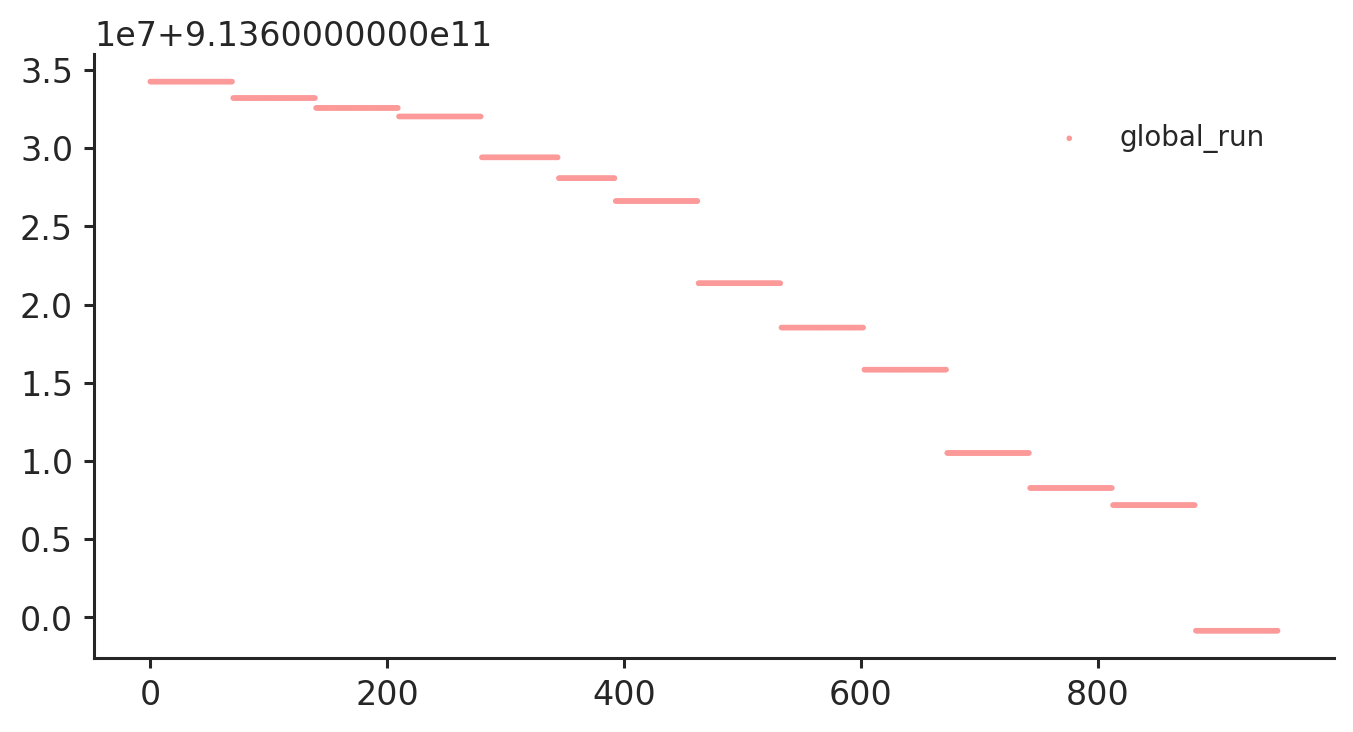

In [170]:
optim_plot(global_run=global_run_res, tail=0.001)

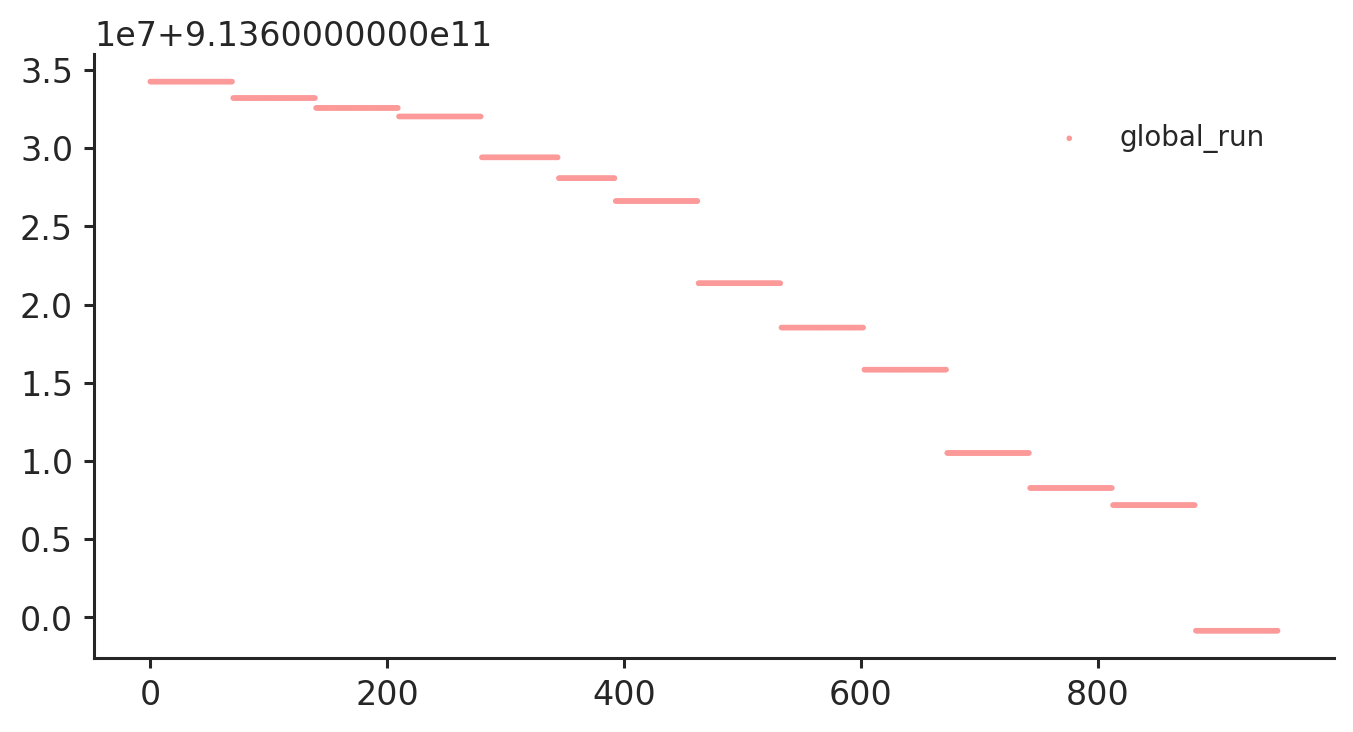

In [104]:
optim_plot(global_run=global_run_res, tail=0.001)

In [171]:
best_theta = nloptim_summary(global_run_res, nt, nf) # 3rd run

NLL: 913599145884.1907
pi0: 0.0018253262059501308

μ: 4.564287647326172e-09
W = 
-----  -----  -----
0.133  0.272  0.506
0.109  0.013  0.289
0.002  0.27   0.002
0.112  0.134  0.137
0.644  0.311  0.067
-----  -----  -----
sums: [1. 1. 1.]


In [105]:
best_theta = nloptim_summary(global_run_res, nt, nf) # 2nd run

NLL: 913599145884.1907
pi0: 0.0018253262059501308

μ: 4.564287647326172e-09
W = 
-----  -----  -----
0.133  0.272  0.506
0.109  0.013  0.289
0.002  0.27   0.002
0.112  0.134  0.137
0.644  0.311  0.067
-----  -----  -----
sums: [1. 1. 1.]


In [401]:
best_theta = nloptim_summary(global_run_res, nt, nf) # first run

NLL: 913570926435.8547
pi0: 0.00195829561471389

μ: 1.232386727173979e-08
W = 
-----  -----  -----
0.574  0.751  0.906
0.002  0.098  0.074
0.044  0.029  0.001
0      0.011  0.012
0.381  0.11   0.008
-----  -----  -----
sums: [1.00161235 1.         1.        ]


### Experimental Perturbation Starts

It could be an issue of choosing the right perturbation scale, but this looked like it didn't work. I think that this is more becausing finding the true MLE in this space is hard — there are lots of local optima that need to be explored.

In [381]:
def trunc_normal(loc, scale, lower, upper):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return np.random.normal(loc, scale)
    return truncnorm.rvs(a, b)

def perturber(theta, log10_pi0_bounds=(-4, -3),
            log10_mu_bounds=(-11, -7), pi0_scale=1e-6, 
            mu_scale=1e-12, dfe_scale=1e-04):
    def func():
        new_theta = np.copy(theta)
        normal = truncnorm.rvs

        new_theta[0] = trunc_normal(theta[0], pi0_scale, 10**log10_pi0_bounds[0], 10**log10_pi0_bounds[1])
        new_theta[1] = trunc_normal(theta[1], mu_scale, 10**log10_mu_bounds[0], 10**log10_mu_bounds[1])
        for i in range(2, theta.size):
            w = theta[i]
            new_theta[i] = trunc_normal(w, dfe_scale, 10**log10_mu_bounds[0]/w, 10**log10_mu_bounds[1]/w)
        return new_theta
    return func

In [382]:
perturb_starts = perturber(best_theta)
run_res = run_nloptims(worker, perturb_starts, 4000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:30<00:00, 130.74it/s]


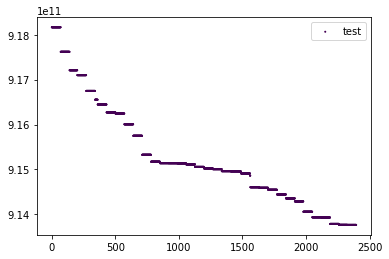

In [383]:
optim_plot(test=run_res, tail=0.6)

## Penalized Methods

Some of the instability of convergence to the optimum is that the model cannot choose between weak or strong mutation (and visa versa for selection). 

We could put a prior on this mutation rate, since we have many other estimates. A recent paper (Tian, Browning, and Browning, 2019) estimated the mutation rate as $\mu = 1.28 \times 10^{-8}$ ($95\%$ CI, $1.02 \times 10^{-8}, 1.56 \times 10^{-8}$).

In [132]:
sigma

6.581753637311707e-09

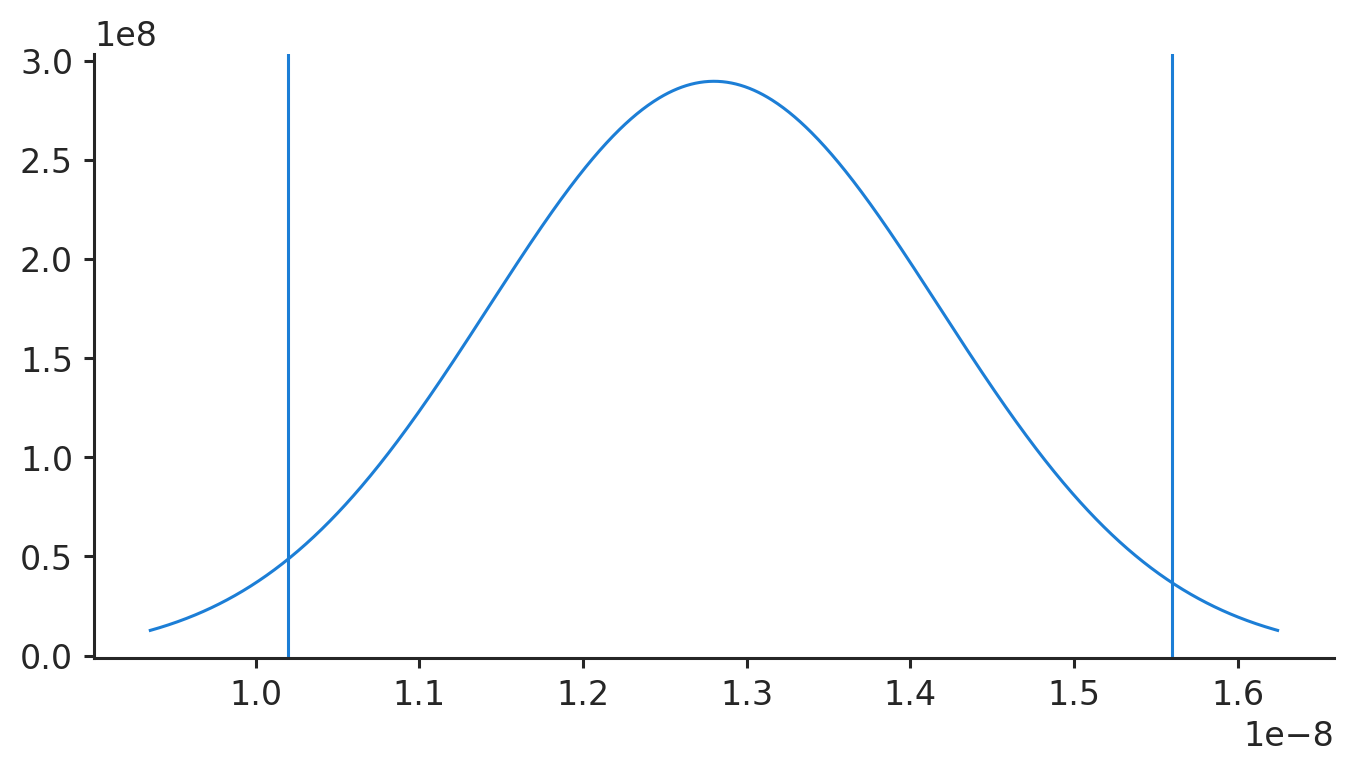

In [169]:
mean = 1.28e-8
ci = [1.02e-8, 1.56e-8]

def ci2params(mean, ci, alpha=0.05):
    crit = stats.norm.ppf(1 - alpha/2)
    sigma1 = (mean-ci[0])/crit
    sigma2 = (ci[1]-mean)/crit
    return mean, np.mean((sigma1, sigma2))

mean, sigma = ci2params(mean, ci)

z = np.linspace(mean - 2.5*sigma, mean + 2.5*sigma, 1000)
y = stats.norm(mean, sigma).pdf(z)
plt.plot(z, y)
#plt.hist(stats.norm(mean, sigma).rvs(10000), 100, density=True)
#plt.axvline(mean -sigma)
plt.axvline(ci[0])
plt.axvline(ci[1])

In [179]:
r = 1/(sigma / 1e3)**2

r, -r * (mean - 4.6e-9)**2 / 2 / 1e11

(5.26949083771485e+23, -0.00017716028196397327)

In [159]:
(mean - 4.6e-9)**2

6.724000000000001e-17

In [182]:
negll_c(best_theta, Y, B, w), penalized_negll_c(best_theta, Y, B, w, 1.23e-8, r = r)

(947520298534.3077, 947536065179.079)

In [ ]:
def penalized_negll_nlopt(Y, B, w, mu0, r):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        return penalized_negll_c(x, Y, B, w, mu0, r)
    return func


def penalized_nlopt_worker(start, nt, nf, mu0, r):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = penalized_negll_nlopt(Y, Bp, w, mu0=mu0, r=r)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-6] * nt*nf))
    #opt.set_ftol_abs(1e8)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(100000)
    x = random_start_simplex(nt, nf)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

N = 100_000

np.random.seed(1)
worker = partial(penalized_nlopt_worker, nt=nt, nf=nf, mu0=1.23e-8, r=5e26) 
penalized_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 66832/100000 [20:39<12:53:20,  1.40s/it]

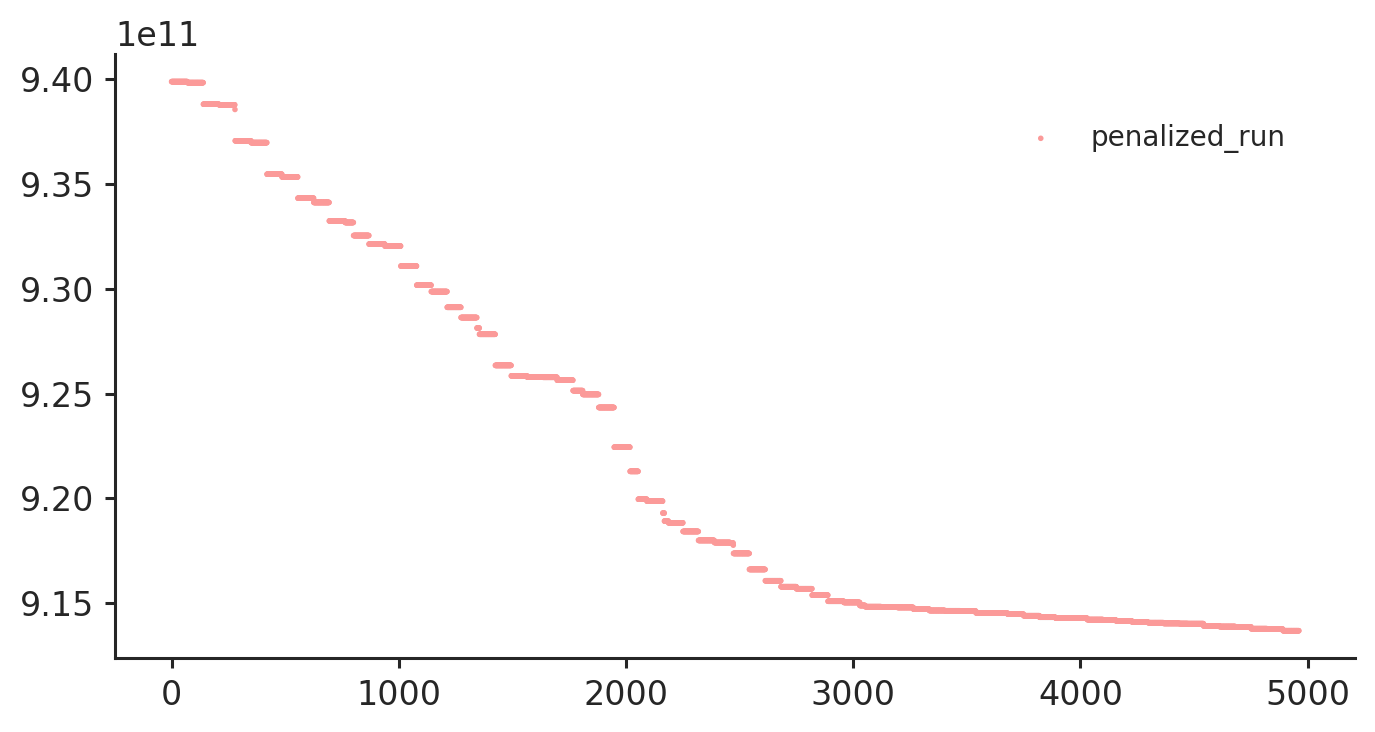

In [210]:
optim_plot(penalized_run=penalized_run_res)

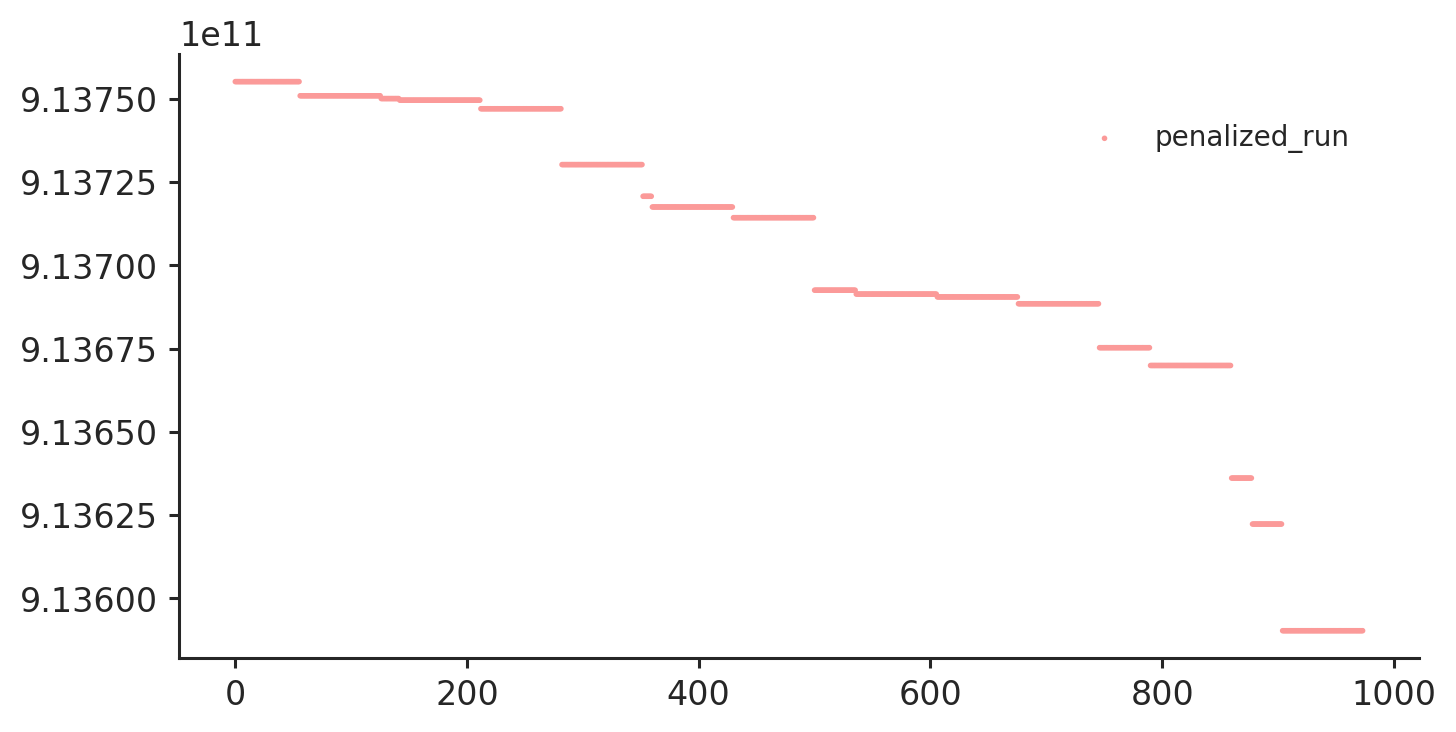

In [215]:
optim_plot(penalized_run=penalized_run_res, tail=0.01)

In [213]:
nloptim_summary(penalized_run_res, nt, nf)

convergence: 100.0%
NLL: 913590305428.1373
pi0: 0.0019860311304504153

μ: 1.2146304777861702e-08
W = 
-----  -----  -----
0.522  0.776  0.786
0.063  0.034  0
0.002  0.007  0.04
0      0.097  0.09
0.413  0.086  0.084
-----  -----  -----
sums: [1. 1. 1.]


array([1.98603113e-03, 1.21463048e-08, 5.22002983e-01, 7.76332917e-01,
       7.86336693e-01, 6.32906590e-02, 3.42746882e-02, 1.01260839e-17,
       1.95654295e-03, 6.53413288e-03, 3.96236721e-02, 8.80567154e-18,
       9.72383752e-02, 9.04432695e-02, 4.12749815e-01, 8.56198870e-02,
       8.35963654e-02])

In [211]:
nloptim_summary(penalized_run_res, nt, nf)

convergence: 100.0%
NLL: 913680208619.4436
pi0: 0.0018699516414047003

μ: 1.2283691105884408e-08
W = 
-----  -----  -----
0.627  0.783  0.752
0.003  0.049  0.034
0      0      0.002
0.017  0.005  0.114
0.37   0.169  0.098
-----  -----  -----
sums: [1.0174961  1.00497626 1.        ]


array([1.86995164e-03, 1.22836911e-08, 6.27148238e-01, 7.82564706e-01,
       7.52499820e-01, 2.59237925e-03, 4.87227843e-02, 3.37434369e-02,
       4.62728495e-17, 2.31364247e-17, 2.20313237e-03, 1.74961007e-02,
       4.97626084e-03, 1.13611051e-01, 3.70259383e-01, 1.68712510e-01,
       9.79425599e-02])

## LIPO Optimization

In [216]:
from lipo import GlobalOptimizer

In [238]:
params = ['pi0'] + [f"w{i}" for i in range(nt*nf)]

In [239]:
glb, gub = [dict(zip(params, x.tolist())) for x in bounds_mutation(nf, nt)]

In [264]:
glb

{'pi0': 0.0001,
 'w0': 1e-11,
 'w1': 1e-11,
 'w2': 1e-11,
 'w3': 1e-11,
 'w4': 1e-11,
 'w5': 1e-11,
 'w6': 1e-11,
 'w7': 1e-11,
 'w8': 1e-11,
 'w9': 1e-11,
 'w10': 1e-11,
 'w11': 1e-11,
 'w12': 1e-11,
 'w13': 1e-11,
 'w14': 1e-11}

In [265]:
for l in [f"w{i}" for i in range(nt*nf)]:
    print(l + ", ", end='')

w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14, 

In [270]:
def negll_freemut_alt(Y, B, w):
    def func(pi0, w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14):
        new_theta = np.zeros(17)
        new_theta[0] = pi0
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14] # times mutation rates        
        return negll_c(new_theta, Y, B, w)
    return func

nllBp = negll_freemut_alt(Y, Bp, w)
nllB = negll_freemut_alt(Y, B, w)

In [273]:
evaluations

[({'pi0': 0.00012569710220299894,
   'w0': 5.184542412758666e-10,
   'w1': 2.0984661616025693e-09,
   'w2': 1.181035917241304e-08,
   'w3': 5.184542412758666e-10,
   'w4': 2.0984661616025693e-09,
   'w5': 1.181035917241304e-08,
   'w6': 5.184542412758666e-10,
   'w7': 2.0984661616025693e-09,
   'w8': 1.181035917241304e-08,
   'w9': 5.184542412758666e-10,
   'w10': 2.0984661616025693e-09,
   'w11': 1.181035917241304e-08,
   'w12': 5.184542412758666e-10,
   'w13': 2.0984661616025693e-09,
   'w14': 1.181035917241304e-08},
  1188291215969.2021)]

In [ ]:
pre_eval_x = dict(zip(params, random_start_mutation(nt, nf).tolist()))
evaluations = [(pre_eval_x, nllBp(**pre_eval_x))]

search = GlobalOptimizer(
    nllBp,
    lower_bounds=glb,
    upper_bounds=gub,
    #categories={"z": ["a", "b"]},
    evaluations=evaluations,
    maximize=False,
)

num_function_calls = 1000
search.run(num_function_calls)

In [ ]:
search.optimum

## Quasi-Monte Carlo Starts

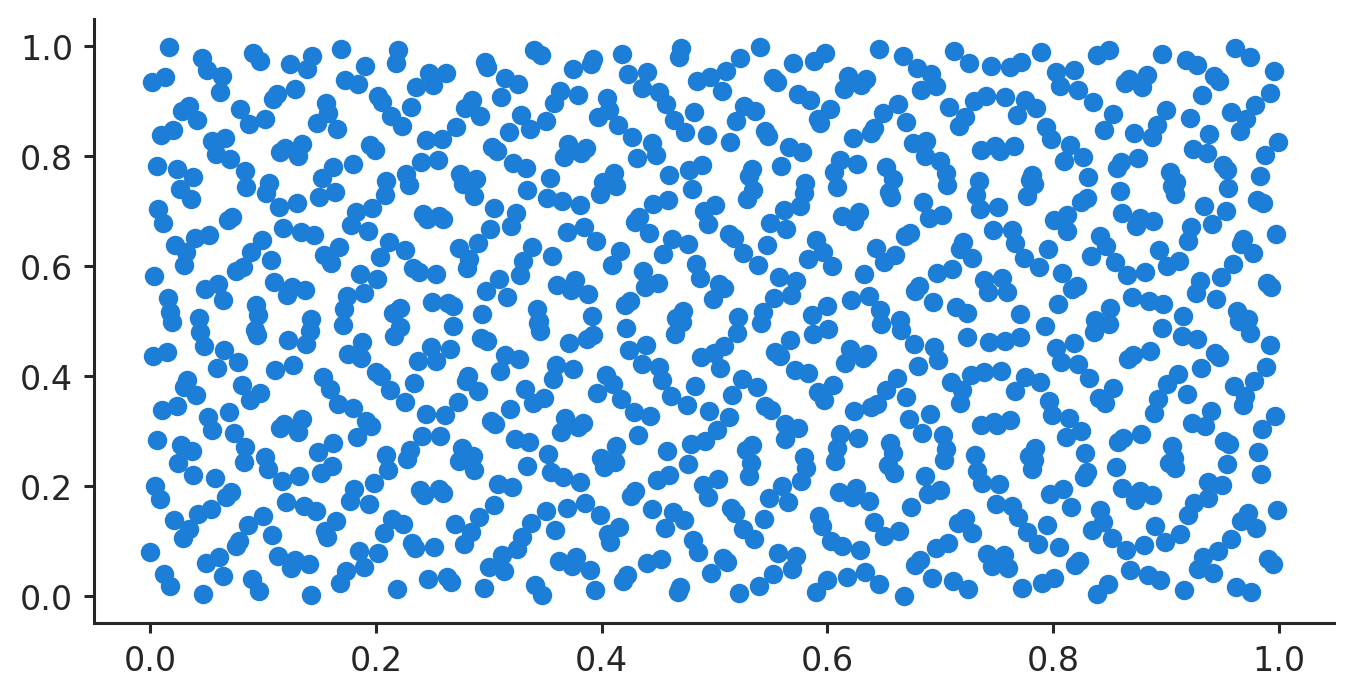

In [96]:
plt.scatter(*Sobol(2).random(1000).T)

In [ ]:
def lowdisc_log

def lowdiscr_start_simplex(nt, nf, log10_pi0_bounds=(-4, -3),
                          log10_mu_bounds=(-11, -7)):
    pi0 = 10**np.random.uniform(log10_pi0_bounds[0], log10_pi0_bounds[1], 1)
    mu = 10**np.random.uniform(log10_mu_bounds[0], log10_mu_bounds[1], 1)
    W = np.empty((nt, nf))
    for i in range(nf):
        W[:, i] = np.random.dirichlet([1.] * nt)
        assert np.abs(W[:, i].sum() - 1.) < 1e-5
    theta = np.empty(nt*nf + 2)
    theta[0] = pi0
    theta[1] = mu
    theta[2:] = W.flat
    check_bounds(theta, *bounds_simplex(nt, nf, log10_pi0_bounds, log10_mu_bounds))
    return theta
